# 0. Import Libraries

In [1]:
import ROOT as root

import numpy as np

import time
import copy

import os.path

Welcome to JupyROOT 6.26/04


---
# 1. Load QC/TDC from Text File

## Description

Takes a formatted text file of calorimeter data and returns 3 data products:
- `QDC`/`TDC`: An n x 8 x 8 array for QDC and TDC values, formatted `QDC[event_index][x_coord][y_coord]`
- `event_num`: An array where `event_num[event_index]` contains the original event number in the uncut run
    - This accomodates input files that already have some PID cuts applied causing event numbers to have gaps, such as filtering only for electron events

## 1.1. Helper Function

In [13]:
def load_TQDC(finPath):
    basePath = "/media/sf_data/"

    # load data from file
    fin = os.path.join(basePath, finPath)
    t0 = time.time()
    raw_data = np.loadtxt(fin, skiprows = 5)
    t1 = time.time()
    print(f"Data file read in {t1-t0:.2f} seconds.")
    # return raw_data

    
    # initialize formatted data array
    num_events = raw_data.shape[0]
    print(f'There are {num_events} events')
    TDC = np.zeros((num_events, 8, 8), dtype=float)
    QDC = np.zeros((num_events, 8, 8), dtype=float)
    event_num = np.zeros((num_events), dtype=int)
    
    
    # format data to [event#][x][y]
    t0 = time.time()
    i_event = -1

    
    for event in raw_data:
        i_event += 1 
        for x in range(8):
            # # this method preserves the original event number, but doesn't work when events aren't one by one
            # TDC [ np.int_(event[0]) ] [x] [:] = event[16*x+1 : 16*x+17 : 2]
            # QDC [ np.int_(event[0]) ] [x] [:] = event[16*x+2 : 16*x+17 : 2]
            
            TDC [i_event] [x] [:] = event[16*x+1 : 16*x+17 : 2]
            QDC [i_event] [x] [:] = event[16*x+2 : 16*x+17 : 2] 
            event_num [i_event] = event[0]
            
    t1 = time.time()
    print(f"Data file formatted to array in {t1-t0:.2f} seconds.")
    
    return TDC, QDC, event_num

## 1.2. Usage

In [14]:
# finPath = "calorimeter/elog_2341/run12130_calo_qdc_tdc_raw.txt"
finPath = "calorimeter/elog_2341/run12130_calo_qdc_tdc_cut.txt" # BH electron PID cut + beam monitor hit cut

TDC, QDC, event_num = load_TQDC(finPath)

Data file read in 32.63 seconds.
There are 674056 events
Data file formatted to array in 6.99 seconds.


---
# 2. 8x8 of QDC/TDC Distributions

## 2.1. Helper Function

In [114]:
def make8x8(datatype, data, xMin, xMax, resolution):

    t0 = time.time()

    nBins = int(xMax / resolution)

    
    # make canvas
    data_canv = root.TCanvas(f"raw_{datatype}_canv", f"{datatype} Bars (counts v channel)")
    data_canv.Divide(8,8)
    
    # fill histograms
    data_hist = [root.TH1F()] * 65
    num_events = data.shape[0]
    
    for x in range(8):
        for y in range(8):
        
            # get pad coordinates
            pad_x = x
            pad_y = -y + 7
            pad_index = pad_x + 8*pad_y + 1 # referenced by CD
        
        
            # fill histogram
            data_hist[pad_index] = root.TH1F(f"bar ({x},{y})", f"bar ({x},{y})", nBins, float(xMin), float(xMax))
            for event in range(num_events):
                data_hist[pad_index].Fill(data[event][x][y])
                
                

                        
                
            # pedestal correction (QDC only)
            if datatype == "QDC":
            
                ## get max bin index and value
                maxBinIndex = 0
                maxBinValue = data_hist[pad_index].GetBinContent(0)
            
                for i_bin in range(nBins):
                    if (data_hist[pad_index].GetBinContent(i_bin) > maxBinValue):
                        maxBinValue = data_hist[pad_index].GetBinContent(i_bin)
                        maxBinIndex = i_bin
            
                ## copy bins leftwards so max bin is at 0
                for i_bin in range(0, nBins - maxBinIndex + 1):
                    data_hist[pad_index].SetBinContent(i_bin, data_hist[pad_index].GetBinContent(i_bin + maxBinIndex))
                    
                ## erase remaining bins on the right edge
                for i_bin in range(nBins-maxBinIndex, nBins + 1):
                    data_hist[pad_index].SetBinContent(i_bin, 0)
                    
                ## recalculate stats
                data_hist[pad_index].PutStats(np.zeros(5))
                    
                    
            # get max value in entire dataset
            maxValue = np.amax(data)

                
                
            # format/draw a deep copy of this histogram
            data_hist[pad_index] = copy.deepcopy(data_hist[pad_index])
            data_hist[pad_index].SetMaximum(maxValue * 1.1)
            data_canv.cd(pad_index)
            if datatype == "QDC":
                data_canv.GetPad(pad_index).SetLogy()
            data_hist[pad_index].Draw()
    
    data_canv.SetCanvasSize(3000,3000)
    
    t1 = time.time()
    print(f"{datatype} histogram created in {t1-t0:.2f} seconds.")
    
    return data_canv, data_hist

## 2.2. Usage

In [116]:
resolution = 10
savePlots = True

QDC_canv, QDC_hist = make8x8("QDC", QDC, 0, 1000, resolution)    
TDC_canv, TDC_hist = make8x8("TDC", TDC, -100, 300, resolution)

if savePlots:
    QDC_canv.Print("cut_QDC_canv.png")
    TDC_canv.Print("cut_TDC_canv.png")

QDC histogram created in 23.60 seconds.
TDC histogram created in 24.02 seconds.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: raw_QDC_canv
Warning in <TCanvas::Constructor>: Deleting canvas with same name: raw_TDC_canv
Info in <TCanvas::Print>: png file cut_QDC_canv.png has been created
Info in <TCanvas::Print>: png file cut_TDC_canv.png has been created


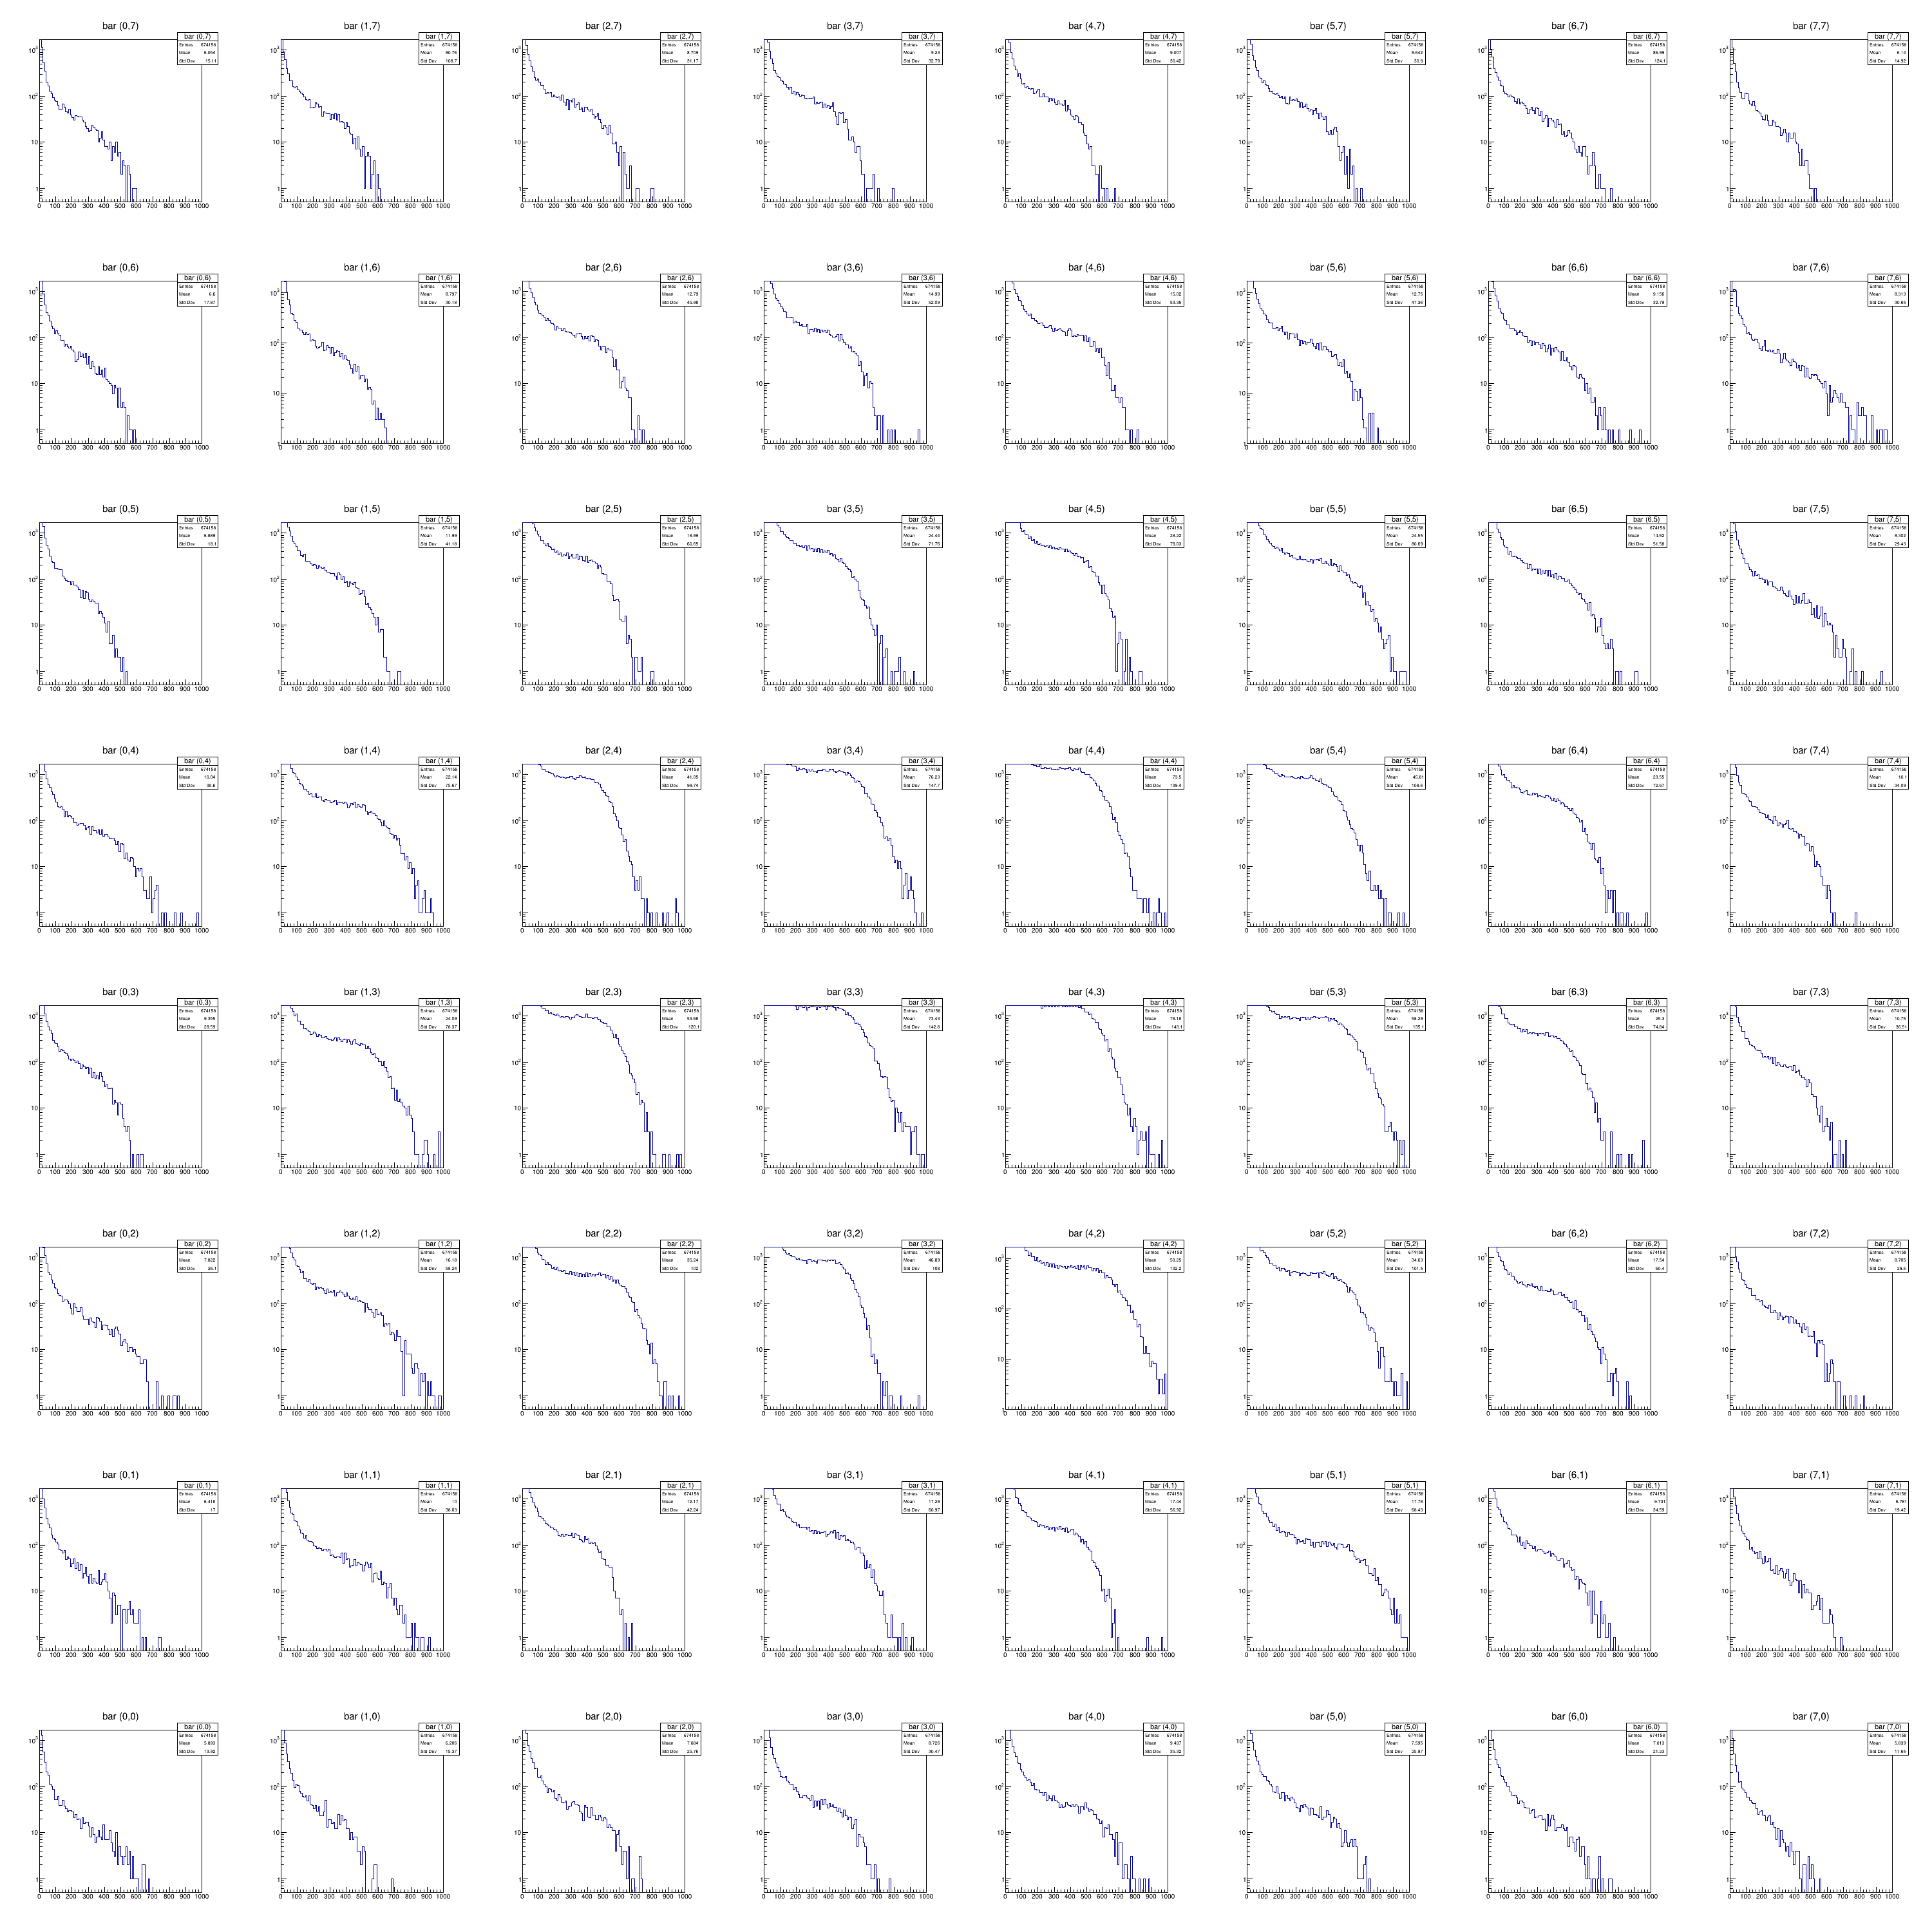

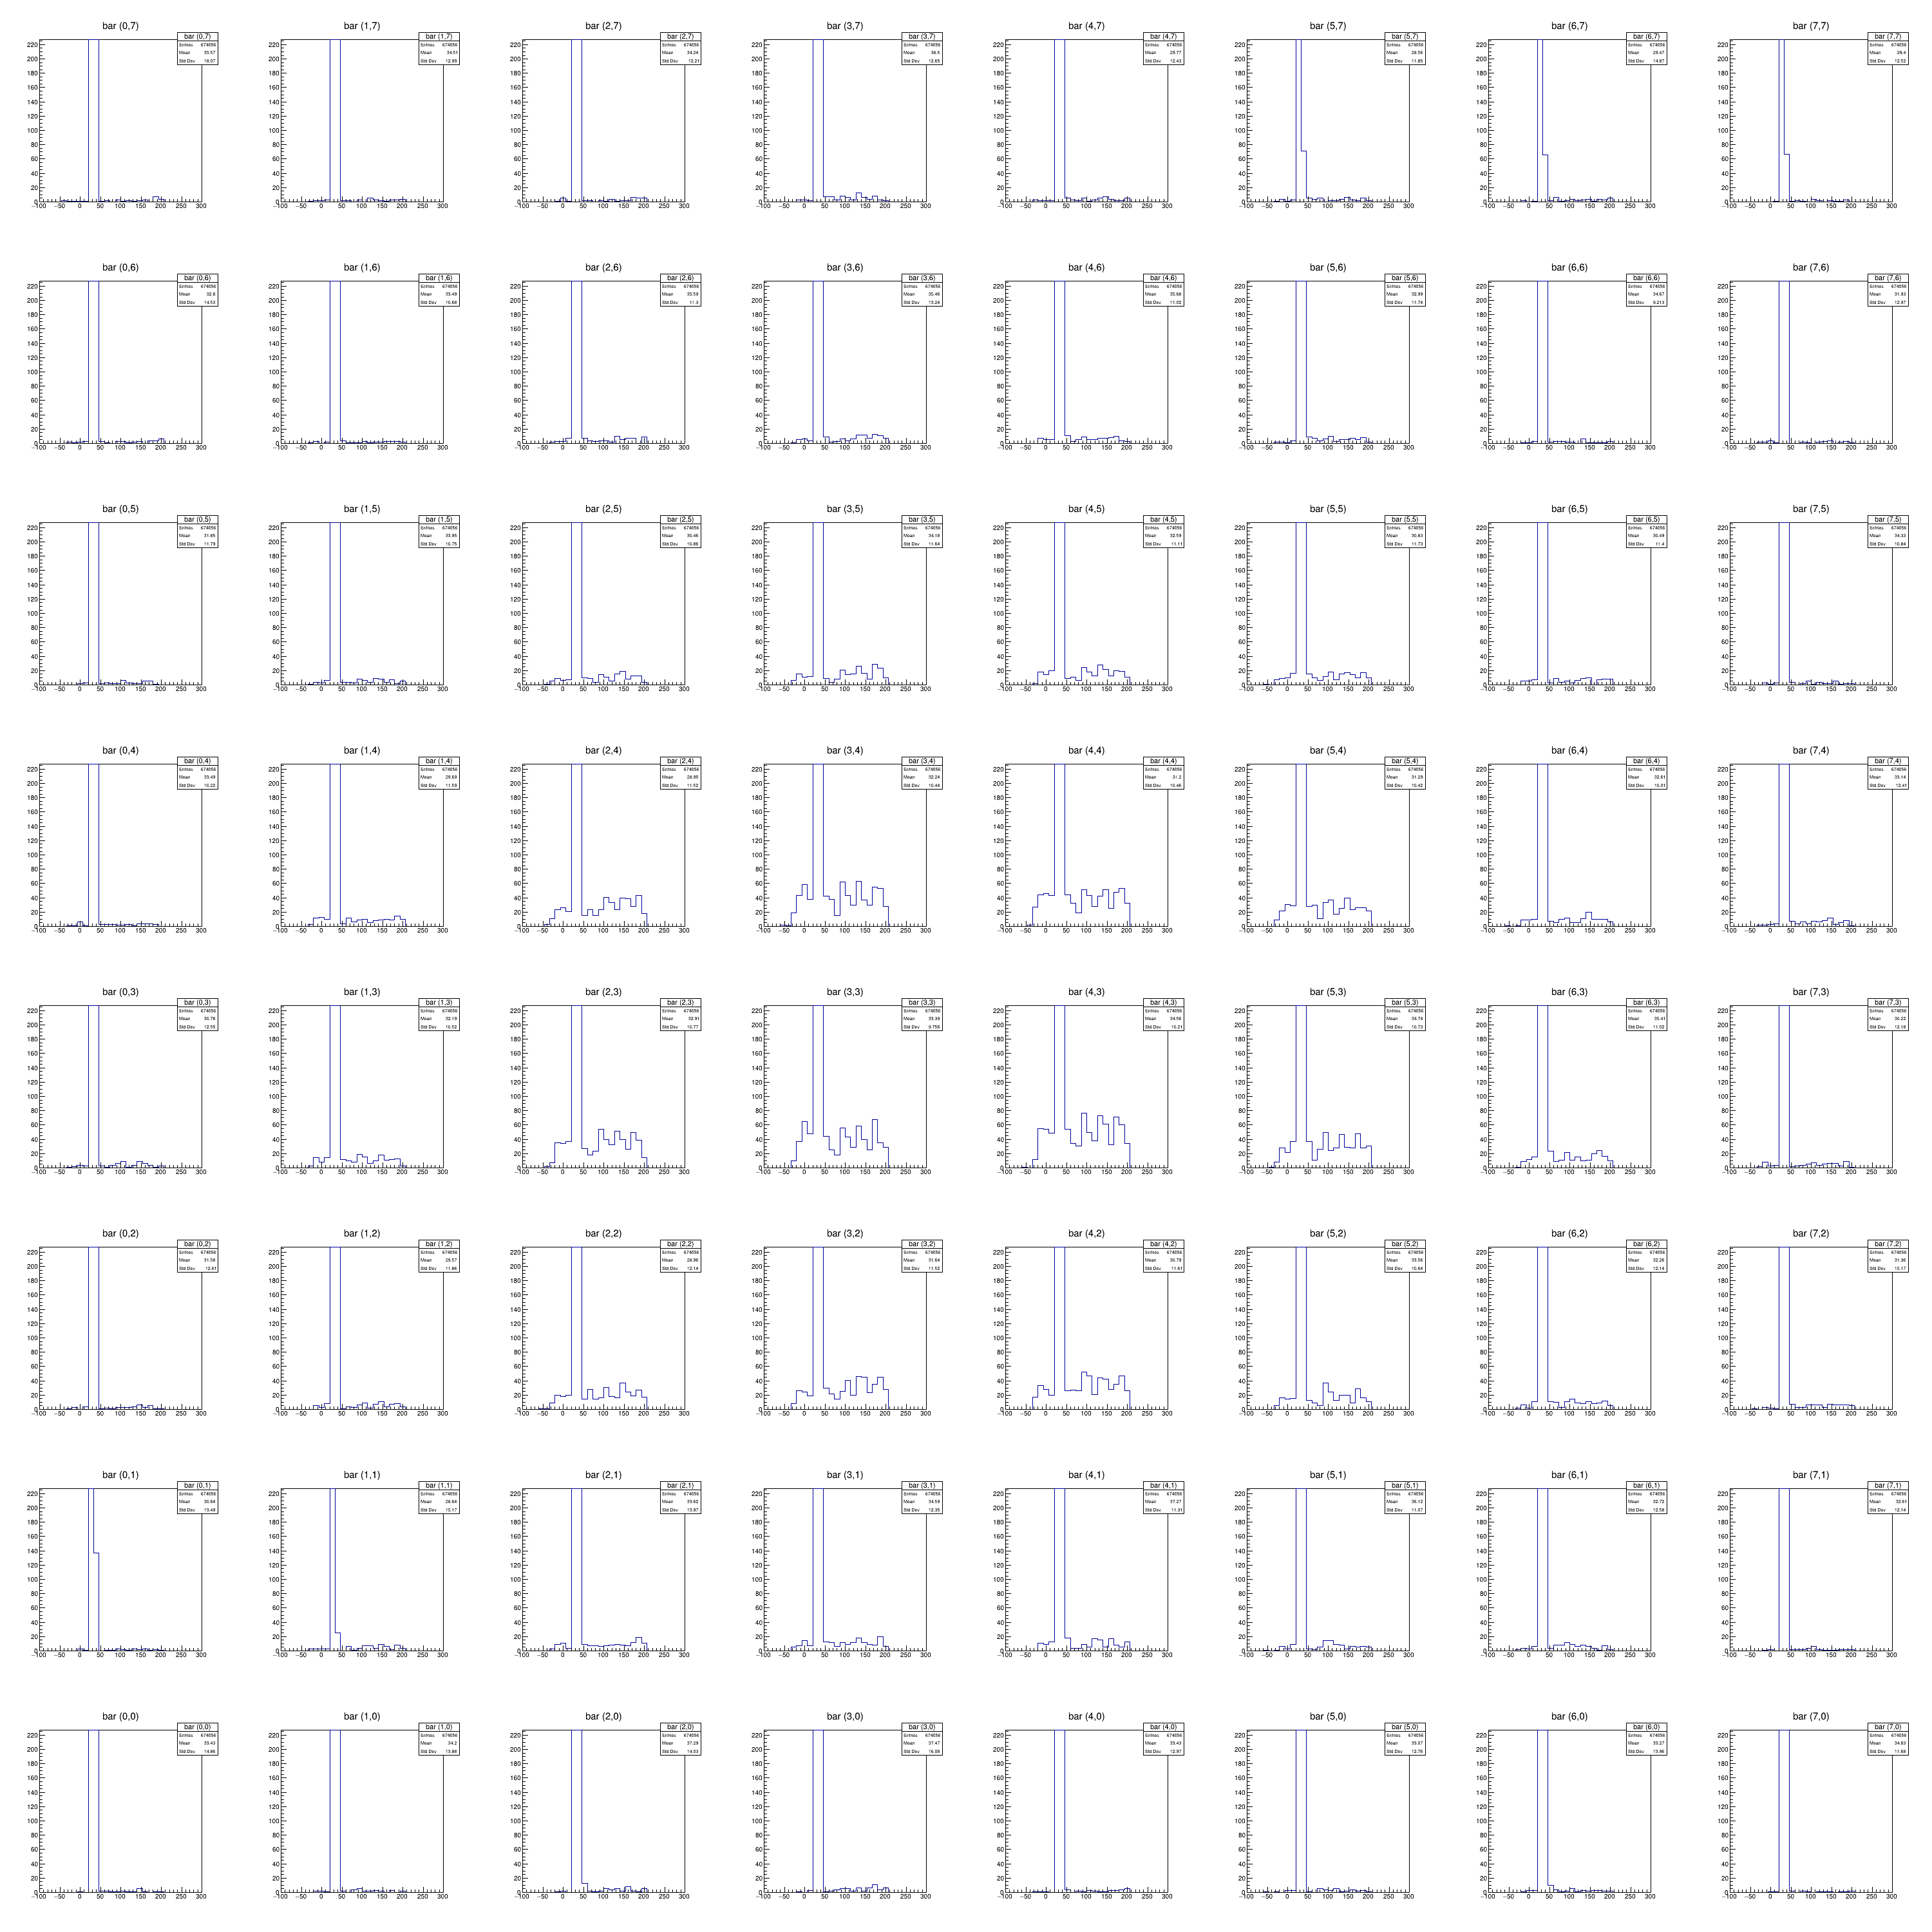

In [173]:
QDC_canv.Draw()
TDC_canv.Draw()